In [1]:
import numpy as np
import random
import math
from PIL import Image
from os.path import *
import re
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)
import os
import os.path as osp
from glob import glob
import torch
from torchvision.transforms import ColorJitter
import torch.utils.data as data
from torch import nn, einsum
import torch.optim as optim
from torch.cuda.amp import GradScaler
import torch.nn.functional as F
from einops import rearrange
from itertools import islice as take
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import flow_vis

In [2]:
TAG_CHAR = np.array([202021.25], np.float32)

## 1. Read/Write files functions

In [3]:
def readFlow(fn):
    """ Read .flo file in Middlebury format"""
    # Code adapted from:
    # http://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy

    # WARNING: this will work on little-endian architectures (eg Intel x86) only!
    # print 'fn = %s'%(fn)
    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            # print 'Reading %d x %d flo file\n' % (w, h)
            data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
            # Reshape data into 3D array (columns, rows, bands)
            # The reshape here is for visualization, the original code is (w,h,2)
            return np.resize(data, (int(h), int(w), 2))
        
def readPFM(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header == b'PF':
        color = True
    elif header == b'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(rb'^(\d+)\s(\d+)\s$', file.readline())
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    return data


def writeFlow(filename,uv,v=None):
    """ Write optical flow to file.
    
    If v is None, uv is assumed to contain both u and v channels,
    stacked in depth.
    Original code by Deqing Sun, adapted from Daniel Scharstein.
    """
    nBands = 2

    if v is None:
        assert(uv.ndim == 3)
        assert(uv.shape[2] == 2)
        u = uv[:,:,0]
        v = uv[:,:,1]
    else:
        u = uv

    assert(u.shape == v.shape)
    height,width = u.shape
    f = open(filename,'wb')
    # write the header
    f.write(TAG_CHAR)
    np.array(width).astype(np.int32).tofile(f)
    np.array(height).astype(np.int32).tofile(f)
    # arrange into matrix form
    tmp = np.zeros((height, width*nBands))
    tmp[:,np.arange(width)*2] = u
    tmp[:,np.arange(width)*2 + 1] = v
    tmp.astype(np.float32).tofile(f)
    f.close()
    
def read_gen(file_name, pil=False):
    ext = splitext(file_name)[-1]
    if ext == '.png' or ext == '.jpeg' or ext == '.ppm' or ext == '.jpg':
        return Image.open(file_name)
    elif ext == '.bin' or ext == '.raw':
        return np.load(file_name)
    elif ext == '.flo':
        return readFlow(file_name).astype(np.float32)
    elif ext == '.pfm':
        flow = readPFM(file_name).astype(np.float32)
        if len(flow.shape) == 2:
            return flow
        else:
            return flow[:, :, :-1]
    return []

## 2. Transformadores y Aumentadores de datos

In [4]:
class FlowAugmentor:
    def __init__(self, crop_size, min_scale=-0.2, max_scale=0.5, do_flip=True):
        
        # spatial augmentation params
        self.crop_size = crop_size
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.spatial_aug_prob = 0.8
        self.stretch_prob = 0.8
        self.max_stretch = 0.2

        # flip augmentation params
        self.do_flip = do_flip
        self.h_flip_prob = 0.5
        self.v_flip_prob = 0.1

        # photometric augmentation params
        self.photo_aug = ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.5/3.14)
        self.asymmetric_color_aug_prob = 0.2
        self.eraser_aug_prob = 0.5

    def color_transform(self, img1, img2):
        """ Photometric augmentation """

        # asymmetric
        if np.random.rand() < self.asymmetric_color_aug_prob:
            img1 = np.array(self.photo_aug(Image.fromarray(img1)), dtype=np.uint8)
            img2 = np.array(self.photo_aug(Image.fromarray(img2)), dtype=np.uint8)

        # symmetric
        else:
            image_stack = np.concatenate([img1, img2], axis=0)
            image_stack = np.array(self.photo_aug(Image.fromarray(image_stack)), dtype=np.uint8)
            img1, img2 = np.split(image_stack, 2, axis=0)

        return img1, img2

    def eraser_transform(self, img1, img2, bounds=[50, 100]):
        """ Occlusion augmentation """

        ht, wd = img1.shape[:2]
        if np.random.rand() < self.eraser_aug_prob:
            mean_color = np.mean(img2.reshape(-1, 3), axis=0)
            for _ in range(np.random.randint(1, 3)):
                x0 = np.random.randint(0, wd)
                y0 = np.random.randint(0, ht)
                dx = np.random.randint(bounds[0], bounds[1])
                dy = np.random.randint(bounds[0], bounds[1])
                img2[y0:y0+dy, x0:x0+dx, :] = mean_color

        return img1, img2

    def spatial_transform(self, img1, img2, flow):
        # randomly sample scale
        ht, wd = img1.shape[:2]
        min_scale = np.maximum(
            (self.crop_size[0] + 8) / float(ht), 
            (self.crop_size[1] + 8) / float(wd))

        scale = 2 ** np.random.uniform(self.min_scale, self.max_scale)
        scale_x = scale
        scale_y = scale
        if np.random.rand() < self.stretch_prob:
            scale_x *= 2 ** np.random.uniform(-self.max_stretch, self.max_stretch)
            scale_y *= 2 ** np.random.uniform(-self.max_stretch, self.max_stretch)
        
        scale_x = np.clip(scale_x, min_scale, None)
        scale_y = np.clip(scale_y, min_scale, None)

        if np.random.rand() < self.spatial_aug_prob:
            # rescale the images
            img1 = cv2.resize(img1, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            img2 = cv2.resize(img2, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            flow = cv2.resize(flow, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            flow = flow * [scale_x, scale_y]

        if self.do_flip:
            if np.random.rand() < self.h_flip_prob: # h-flip
                img1 = img1[:, ::-1]
                img2 = img2[:, ::-1]
                flow = flow[:, ::-1] * [-1.0, 1.0]

            if np.random.rand() < self.v_flip_prob: # v-flip
                img1 = img1[::-1, :]
                img2 = img2[::-1, :]
                flow = flow[::-1, :] * [1.0, -1.0]

        y0 = np.random.randint(0, img1.shape[0] - self.crop_size[0])
        x0 = np.random.randint(0, img1.shape[1] - self.crop_size[1])
        
        img1 = img1[y0:y0+self.crop_size[0], x0:x0+self.crop_size[1]]
        img2 = img2[y0:y0+self.crop_size[0], x0:x0+self.crop_size[1]]
        flow = flow[y0:y0+self.crop_size[0], x0:x0+self.crop_size[1]]

        return img1, img2, flow

    def __call__(self, img1, img2, flow):
        img1, img2 = self.color_transform(img1, img2)
        img1, img2 = self.eraser_transform(img1, img2)
        img1, img2, flow = self.spatial_transform(img1, img2, flow)

        img1 = np.ascontiguousarray(img1)
        img2 = np.ascontiguousarray(img2)
        flow = np.ascontiguousarray(flow)

        return img1, img2, flow
    
    
class SparseFlowAugmentor:
    def __init__(self, crop_size, min_scale=-0.2, max_scale=0.5, do_flip=False):
        # spatial augmentation params
        self.crop_size = crop_size
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.spatial_aug_prob = 0.8
        self.stretch_prob = 0.8
        self.max_stretch = 0.2

        # flip augmentation params
        self.do_flip = do_flip
        self.h_flip_prob = 0.5
        self.v_flip_prob = 0.1

        # photometric augmentation params
        self.photo_aug = ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3/3.14)
        self.asymmetric_color_aug_prob = 0.2
        self.eraser_aug_prob = 0.5
        
    def color_transform(self, img1, img2):
        image_stack = np.concatenate([img1, img2], axis=0)
        image_stack = np.array(self.photo_aug(Image.fromarray(image_stack)), dtype=np.uint8)
        img1, img2 = np.split(image_stack, 2, axis=0)
        return img1, img2

    def eraser_transform(self, img1, img2):
        ht, wd = img1.shape[:2]
        if np.random.rand() < self.eraser_aug_prob:
            mean_color = np.mean(img2.reshape(-1, 3), axis=0)
            for _ in range(np.random.randint(1, 3)):
                x0 = np.random.randint(0, wd)
                y0 = np.random.randint(0, ht)
                dx = np.random.randint(50, 100)
                dy = np.random.randint(50, 100)
                img2[y0:y0+dy, x0:x0+dx, :] = mean_color

        return img1, img2

    def resize_sparse_flow_map(self, flow, valid, fx=1.0, fy=1.0):
        ht, wd = flow.shape[:2]
        coords = np.meshgrid(np.arange(wd), np.arange(ht))
        coords = np.stack(coords, axis=-1)

        coords = coords.reshape(-1, 2).astype(np.float32)
        flow = flow.reshape(-1, 2).astype(np.float32)
        valid = valid.reshape(-1).astype(np.float32)

        coords0 = coords[valid>=1]
        flow0 = flow[valid>=1]

        ht1 = int(round(ht * fy))
        wd1 = int(round(wd * fx))

        coords1 = coords0 * [fx, fy]
        flow1 = flow0 * [fx, fy]

        xx = np.round(coords1[:,0]).astype(np.int32)
        yy = np.round(coords1[:,1]).astype(np.int32)

        v = (xx > 0) & (xx < wd1) & (yy > 0) & (yy < ht1)
        xx = xx[v]
        yy = yy[v]
        flow1 = flow1[v]

        flow_img = np.zeros([ht1, wd1, 2], dtype=np.float32)
        valid_img = np.zeros([ht1, wd1], dtype=np.int32)

        flow_img[yy, xx] = flow1
        valid_img[yy, xx] = 1

        return flow_img, valid_img

    def spatial_transform(self, img1, img2, flow, valid):
        # randomly sample scale

        ht, wd = img1.shape[:2]
        min_scale = np.maximum(
            (self.crop_size[0] + 1) / float(ht), 
            (self.crop_size[1] + 1) / float(wd))

        scale = 2 ** np.random.uniform(self.min_scale, self.max_scale)
        scale_x = np.clip(scale, min_scale, None)
        scale_y = np.clip(scale, min_scale, None)

        if np.random.rand() < self.spatial_aug_prob:
            # rescale the images
            img1 = cv2.resize(img1, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            img2 = cv2.resize(img2, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
            flow, valid = self.resize_sparse_flow_map(flow, valid, fx=scale_x, fy=scale_y)

        if self.do_flip:
            if np.random.rand() < 0.5: # h-flip
                img1 = img1[:, ::-1]
                img2 = img2[:, ::-1]
                flow = flow[:, ::-1] * [-1.0, 1.0]
                valid = valid[:, ::-1]

        margin_y = 20
        margin_x = 50

        y0 = np.random.randint(0, img1.shape[0] - self.crop_size[0] + margin_y)
        x0 = np.random.randint(-margin_x, img1.shape[1] - self.crop_size[1] + margin_x)

        y0 = np.clip(y0, 0, img1.shape[0] - self.crop_size[0])
        x0 = np.clip(x0, 0, img1.shape[1] - self.crop_size[1])

        img1 = img1[y0:y0+self.crop_size[0], x0:x0+self.crop_size[1]]
        img2 = img2[y0:y0+self.crop_size[0], x0:x0+self.crop_size[1]]
        flow = flow[y0:y0+self.crop_size[0], x0:x0+self.crop_size[1]]
        valid = valid[y0:y0+self.crop_size[0], x0:x0+self.crop_size[1]]
        return img1, img2, flow, valid

    def __call__(self, img1, img2, flow, valid):
        img1, img2 = self.color_transform(img1, img2)
        img1, img2 = self.eraser_transform(img1, img2)
        img1, img2, flow, valid = self.spatial_transform(img1, img2, flow, valid)

        img1 = np.ascontiguousarray(img1)
        img2 = np.ascontiguousarray(img2)
        flow = np.ascontiguousarray(flow)
        valid = np.ascontiguousarray(valid)

        return img1, img2, flow, valid

## 3. Datasets

In [5]:
class FlowDataset(data.Dataset):
    def __init__(self, aug_params=None, sparse=False):
        self.augmentor = None
        self.sparse = sparse
        if aug_params is not None:
            if sparse:
                self.augmentor = SparseFlowAugmentor(**aug_params)
            else:
                self.augmentor = FlowAugmentor(**aug_params)

        self.is_test = False
        self.init_seed = False
        self.flow_list = []
        self.image_list = []
        self.extra_info = []
        self.occ_list = None
        self.seg_list = None
        self.seg_inv_list = None

    def __getitem__(self, index):

        if self.is_test:
            img1 = read_gen(self.image_list[index][0])
            img2 = read_gen(self.image_list[index][1])
            img1 = np.array(img1).astype(np.uint8)[..., :3]
            img2 = np.array(img2).astype(np.uint8)[..., :3]
            img1 = torch.from_numpy(img1).permute(2, 0, 1).float()
            img2 = torch.from_numpy(img2).permute(2, 0, 1).float()
            return img1, img2, self.extra_info[index]

        if not self.init_seed:
            worker_info = torch.utils.data.get_worker_info()
            if worker_info is not None:
                torch.manual_seed(worker_info.id)
                np.random.seed(worker_info.id)
                random.seed(worker_info.id)
                self.init_seed = True

        index = index % len(self.image_list)
        valid = None
        if self.sparse:
            flow, valid = readFlowKITTI(self.flow_list[index])
        else:
            flow = read_gen(self.flow_list[index])

        if self.occ_list is not None:
            occ = read_gen(self.occ_list[index])
            occ = np.array(occ).astype(np.uint8)
            occ = torch.from_numpy(occ // 255).bool()

        if self.seg_list is not None:
            f_in = np.array(read_gen(self.seg_list[index]))
            seg_r = f_in[:, :, 0].astype('int32')
            seg_g = f_in[:, :, 1].astype('int32')
            seg_b = f_in[:, :, 2].astype('int32')
            seg_map = (seg_r * 256 + seg_g) * 256 + seg_b
            seg_map = torch.from_numpy(seg_map)

        if self.seg_inv_list is not None:
            seg_inv = read_gen(self.seg_inv_list[index])
            seg_inv = np.array(seg_inv).astype(np.uint8)
            seg_inv = torch.from_numpy(seg_inv // 255).bool()

        img1 = read_gen(self.image_list[index][0])
        img2 = read_gen(self.image_list[index][1])

        flow = np.array(flow).astype(np.float32)
        img1 = np.array(img1).astype(np.uint8)
        img2 = np.array(img2).astype(np.uint8)

        # grayscale images
        if len(img1.shape) == 2:
            img1 = np.tile(img1[...,None], (1, 1, 3))
            img2 = np.tile(img2[...,None], (1, 1, 3))
        else:
            img1 = img1[..., :3]
            img2 = img2[..., :3]

        if self.augmentor is not None:
            if self.sparse:
                img1, img2, flow, valid = self.augmentor(img1, img2, flow, valid)
            else:
                img1, img2, flow = self.augmentor(img1, img2, flow)

        img1 = torch.from_numpy(img1).permute(2, 0, 1).float()
        img2 = torch.from_numpy(img2).permute(2, 0, 1).float()
        flow = torch.from_numpy(flow).permute(2, 0, 1).float()

        if valid is not None:
            valid = torch.from_numpy(valid)
        else:
            valid = (flow[0].abs() < 1000) & (flow[1].abs() < 1000)

        if self.occ_list is not None:
            return img1, img2, flow, valid.float(), occ, self.occ_list[index]
        elif self.seg_list is not None and self.seg_inv_list is not None:
            return img1, img2, flow, valid.float(), seg_map, seg_inv
        else:
            return img1, img2, flow, valid.float()#, self.extra_info[index]

    def __rmul__(self, v):
        self.flow_list = v * self.flow_list
        self.image_list = v * self.image_list
        return self
        
    def __len__(self):
        return len(self.image_list)
    
    
class FlyingThings3D(FlowDataset):
    def __init__(self, aug_params=None, root='/home/zac/data/FlyingThings3D', split='training', dstype='frames_cleanpass'):
        super(FlyingThings3D, self).__init__(aug_params)

        if split == 'training':
            for cam in ['left']:
                for direction in ['into_future', 'into_past']:
                    image_dirs = sorted(glob(osp.join(root, dstype, 'TRAIN/*/*')))
                    image_dirs = sorted([osp.join(f, cam) for f in image_dirs])

                    flow_dirs = sorted(glob(osp.join(root, 'optical_flow/TRAIN/*/*')))
                    flow_dirs = sorted([osp.join(f, direction, cam) for f in flow_dirs])

                    for idir, fdir in zip(image_dirs, flow_dirs):
                        images = sorted(glob(osp.join(idir, '*.png')) )
                        flows = sorted(glob(osp.join(fdir, '*.pfm')) )
                        for i in range(len(flows)-1):
                            if direction == 'into_future':
                                self.image_list += [ [images[i], images[i+1]] ]
                                self.flow_list += [ flows[i] ]
                            elif direction == 'into_past':
                                self.image_list += [ [images[i+1], images[i]] ]
                                self.flow_list += [ flows[i+1] ]

        elif split == 'validation':
            for cam in ['left']:
                for direction in ['into_future', 'into_past']:
                    image_dirs = sorted(glob(osp.join(root, dstype, 'TEST/*/*')))
                    image_dirs = sorted([osp.join(f, cam) for f in image_dirs])

                    flow_dirs = sorted(glob(osp.join(root, 'optical_flow/TEST/*/*')))
                    flow_dirs = sorted([osp.join(f, direction, cam) for f in flow_dirs])

                    for idir, fdir in zip(image_dirs, flow_dirs):
                        images = sorted(glob(osp.join(idir, '*.png')))
                        flows = sorted(glob(osp.join(fdir, '*.pfm')))
                        for i in range(len(flows) - 1):
                            if direction == 'into_future':
                                self.image_list += [[images[i], images[i + 1]]]
                                self.flow_list += [flows[i]]
                            elif direction == 'into_past':
                                self.image_list += [[images[i + 1], images[i]]]
                                self.flow_list += [flows[i + 1]]

                valid_list = np.loadtxt('things_val_test_set.txt', dtype=np.int32)
                self.image_list = [self.image_list[ind] for ind, sel in enumerate(valid_list) if sel]
                self.flow_list = [self.flow_list[ind] for ind, sel in enumerate(valid_list) if sel]    
    
    
class MpiSintel(FlowDataset):
    def __init__(self, aug_params=None, split='training', root='/home/zac/data/Sintel', dstype='clean',
                 occlusion=False, segmentation=False):
        super(MpiSintel, self).__init__(aug_params)
        flow_root = osp.join(root, split, 'flow')
        image_root = osp.join(root, split, dstype)
        # occ_root = osp.join(root, split, 'occlusions')
        # occ_root = osp.join(root, split, 'occ_plus_out')
        # occ_root = osp.join(root, split, 'in_frame_occ')
        occ_root = osp.join(root, split, 'out_of_frame')

        seg_root = osp.join(root, split, 'segmentation')
        seg_inv_root = osp.join(root, split, 'segmentation_invalid')
        self.segmentation = segmentation
        self.occlusion = occlusion
        if self.occlusion:
            self.occ_list = []
        if self.segmentation:
            self.seg_list = []
            self.seg_inv_list = []

        if split == 'test':
            self.is_test = True

        for scene in os.listdir(image_root):
            image_list = sorted(glob(osp.join(image_root, scene, '*.png')))
            for i in range(len(image_list)-1):
                self.image_list += [ [image_list[i], image_list[i+1]] ]
                self.extra_info += [ (scene, i) ] # scene and frame_id

            if split != 'test':
                self.flow_list += sorted(glob(osp.join(flow_root, scene, '*.flo')))
                if self.occlusion:
                    self.occ_list += sorted(glob(osp.join(occ_root, scene, '*.png')))
                if self.segmentation:
                    self.seg_list += sorted(glob(osp.join(seg_root, scene, '*.png')))
                    self.seg_inv_list += sorted(glob(osp.join(seg_inv_root, scene, '*.png')))
                    
                    
def fetch_dataloader(args, TRAIN_DS='C+T+K+S+H'):
    """ Create the data loader for the corresponding training set """

    if args["stage"] == 'chairs':
        aug_params = {'crop_size': args["image_size"], 'min_scale': -0.1, 'max_scale': 1.0, 'do_flip': True}
        dataset = FlyingChairs(aug_params, split=args['dataset'])
    
    elif args["stage"] == 'things':
        aug_params = {'crop_size': args["image_size"], 'min_scale': -0.4, 'max_scale': 0.8, 'do_flip': True}
        clean_dataset = FlyingThings3D(aug_params, dstype='frames_cleanpass', split=args['dataset'])
        final_dataset = FlyingThings3D(aug_params, dstype='frames_finalpass', split=args['dataset'])
        dataset = clean_dataset + final_dataset

    elif args["stage"] == 'sintel':
        aug_params = {'crop_size': args["image_size"], 'min_scale': -0.2, 'max_scale': 0.6, 'do_flip': True}
        if args["dataset"] == "test":
            aug_params=None
        sintel_clean = MpiSintel(aug_params, root=args["data_path"], split=args['dataset'], dstype='clean')
        sintel_final = MpiSintel(aug_params, root=args["data_path"], split=args['dataset'], dstype='final')        

        if TRAIN_DS == 'C+T+K+S+H':
            things = FlyingThings3D(aug_params, dstype='frames_cleanpass')
            kitti = KITTI({'crop_size': args["image_size"], 'min_scale': -0.3, 'max_scale': 0.5, 'do_flip': True})
            hd1k = HD1K({'crop_size': args["image_size"], 'min_scale': -0.5, 'max_scale': 0.2, 'do_flip': True})
            dataset = 100*sintel_clean + 100*sintel_final + 200*kitti + 5*hd1k + things

        elif TRAIN_DS == 'C+T+K/S':
            things = FlyingThings3D(aug_params, dstype='frames_cleanpass')
            dataset = 100*sintel_clean + 100*sintel_final + things
        else:
            if args["dataset"] == "test":
                dataset = sintel_clean + sintel_final
            else:
                dataset = 100*sintel_clean + 100*sintel_final

    elif args["stage"] == 'kitti':
        aug_params = {'crop_size': args["image_size"], 'min_scale': -0.2, 'max_scale': 0.4, 'do_flip': False}
        dataset = KITTI(aug_params, split=args['dataset'])

    data_loader = data.DataLoader(dataset, batch_size=args["batch_size"],
                                   pin_memory=True, shuffle=True, num_workers=8, drop_last=True)

    print(args['dataset'].capitalize()+' dataset with %d image pairs' % len(dataset))
    return data_loader

## 4. Arquitectura GMA

#### Extractor de características

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, norm_fn='group', stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

        num_groups = planes // 8

        if norm_fn == 'group':
            self.norm1 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            self.norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            if not stride == 1:
                self.norm3 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)

        elif norm_fn == 'batch':
            self.norm1 = nn.BatchNorm2d(planes)
            self.norm2 = nn.BatchNorm2d(planes)
            if not stride == 1:
                self.norm3 = nn.BatchNorm2d(planes)

        elif norm_fn == 'instance':
            self.norm1 = nn.InstanceNorm2d(planes)
            self.norm2 = nn.InstanceNorm2d(planes)
            if not stride == 1:
                self.norm3 = nn.InstanceNorm2d(planes)

        elif norm_fn == 'none':
            self.norm1 = nn.Sequential()
            self.norm2 = nn.Sequential()
            if not stride == 1:
                self.norm3 = nn.Sequential()

        if stride == 1:
            self.downsample = None

        else:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride), self.norm3)

    def forward(self, x):
        y = x
        y = self.relu(self.norm1(self.conv1(y)))
        y = self.relu(self.norm2(self.conv2(y)))

        if self.downsample is not None:
            x = self.downsample(x)

        return self.relu(x + y)


class BasicEncoder(nn.Module):
    def __init__(self, output_dim=128, norm_fn='batch', dropout=0.0):
        super(BasicEncoder, self).__init__()
        self.norm_fn = norm_fn

        if self.norm_fn == 'group':
            self.norm1 = nn.GroupNorm(num_groups=8, num_channels=64)

        elif self.norm_fn == 'batch':
            self.norm1 = nn.BatchNorm2d(64)

        elif self.norm_fn == 'instance':
            self.norm1 = nn.InstanceNorm2d(64)

        elif self.norm_fn == 'none':
            self.norm1 = nn.Sequential()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)

        self.in_planes = 64
        self.layer1 = self._make_layer(64, stride=1)
        self.layer2 = self._make_layer(96, stride=2)
        self.layer3 = self._make_layer(128, stride=2)

        # output convolution
        self.conv2 = nn.Conv2d(128, output_dim, kernel_size=1)

        self.dropout = None
        if dropout > 0:
            self.dropout = nn.Dropout2d(p=dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d, nn.GroupNorm)):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def _make_layer(self, dim, stride=1):
        layer1 = ResidualBlock(self.in_planes, dim, self.norm_fn, stride=stride)
        layer2 = ResidualBlock(dim, dim, self.norm_fn, stride=1)
        layers = (layer1, layer2)

        self.in_planes = dim
        return nn.Sequential(*layers)

    def forward(self, x):

        # if input is list, combine batch dimension
        is_list = isinstance(x, tuple) or isinstance(x, list)
        if is_list:
            batch_dim = x[0].shape[0]
            x = torch.cat(x, dim=0)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.conv2(x)

        if self.training and self.dropout is not None:
            x = self.dropout(x)

        if is_list:
            x = torch.split(x, [batch_dim, batch_dim], dim=0)

        return x

#### Bloque de correlación (volumen de correlación)

In [7]:
def bilinear_sampler(img, coords, mode='bilinear', mask=False):
    """ Wrapper for grid_sample, uses pixel coordinates """
    H, W = img.shape[-2:]
    xgrid, ygrid = coords.split([1,1], dim=-1)
    xgrid = 2*xgrid/(W-1) - 1
    ygrid = 2*ygrid/(H-1) - 1

    grid = torch.cat([xgrid, ygrid], dim=-1)
    img = F.grid_sample(img, grid, align_corners=True)

    if mask:
        mask = (xgrid > -1) & (ygrid > -1) & (xgrid < 1) & (ygrid < 1)
        return img, mask.float()

    return img


class CorrBlock:
    def __init__(self, fmap1, fmap2, num_levels=4, radius=4):
        self.num_levels = num_levels
        self.radius = radius
        self.corr_pyramid = []

        # all pairs correlation
        corr = CorrBlock.corr(fmap1, fmap2)

        batch, h1, w1, dim, h2, w2 = corr.shape
        corr = corr.reshape(batch * h1 * w1, dim, h2, w2)

        self.corr_pyramid.append(corr)
        for i in range(self.num_levels - 1):
            corr = F.avg_pool2d(corr, 2, stride=2)
            self.corr_pyramid.append(corr)

    def __call__(self, coords):
        r = self.radius
        coords = coords.permute(0, 2, 3, 1)
        batch, h1, w1, _ = coords.shape

        out_pyramid = []
        for i in range(self.num_levels):
            corr = self.corr_pyramid[i]
            dx = torch.linspace(-r, r, 2 * r + 1)
            dy = torch.linspace(-r, r, 2 * r + 1)
            delta = torch.stack(torch.meshgrid(dy, dx), axis=-1).to(coords.device)

            centroid_lvl = coords.reshape(batch * h1 * w1, 1, 1, 2) / 2 ** i
            delta_lvl = delta.view(1, 2 * r + 1, 2 * r + 1, 2)
            coords_lvl = centroid_lvl + delta_lvl

            corr = bilinear_sampler(corr, coords_lvl)
            corr = corr.view(batch, h1, w1, -1)
            out_pyramid.append(corr)

        out = torch.cat(out_pyramid, dim=-1)
        return out.permute(0, 3, 1, 2).contiguous().float()

    @staticmethod
    def corr(fmap1, fmap2):
        batch, dim, ht, wd = fmap1.shape
        fmap1 = fmap1.view(batch, dim, ht * wd)
        fmap2 = fmap2.view(batch, dim, ht * wd)

        corr = torch.matmul(fmap1.transpose(1, 2), fmap2)
        corr = corr.view(batch, ht, wd, 1, ht, wd)
        return corr / torch.sqrt(torch.tensor(dim).float())

#### Bloque de actualización

In [8]:
class Aggregate(nn.Module):
    def __init__(
        self,
        args,
        dim,
        heads = 4,
        dim_head = 128,
    ):
        super().__init__()
        self.args = args
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = heads * dim_head

        self.to_v = nn.Conv2d(dim, inner_dim, 1, bias=False)

        self.gamma = nn.Parameter(torch.zeros(1))

        if dim != inner_dim:
            self.project = nn.Conv2d(inner_dim, dim, 1, bias=False)
        else:
            self.project = None

    def forward(self, attn, fmap):
        heads, b, c, h, w = self.heads, *fmap.shape

        v = self.to_v(fmap)
        v = rearrange(v, 'b (h d) x y -> b h (x y) d', h=heads)
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)

        if self.project is not None:
            out = self.project(out)

        out = fmap + self.gamma * out

        return out


class FlowHead(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256):
        super(FlowHead, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, hidden_dim, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, 2, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class SepConvGRU(nn.Module):
    def __init__(self, hidden_dim=128, input_dim=192+128):
        super(SepConvGRU, self).__init__()
        self.convz1 = nn.Conv2d(hidden_dim+input_dim, hidden_dim, (1,5), padding=(0,2))
        self.convr1 = nn.Conv2d(hidden_dim+input_dim, hidden_dim, (1,5), padding=(0,2))
        self.convq1 = nn.Conv2d(hidden_dim+input_dim, hidden_dim, (1,5), padding=(0,2))

        self.convz2 = nn.Conv2d(hidden_dim+input_dim, hidden_dim, (5,1), padding=(2,0))
        self.convr2 = nn.Conv2d(hidden_dim+input_dim, hidden_dim, (5,1), padding=(2,0))
        self.convq2 = nn.Conv2d(hidden_dim+input_dim, hidden_dim, (5,1), padding=(2,0))


    def forward(self, h, x):
        # horizontal
        hx = torch.cat([h, x], dim=1)
        z = torch.sigmoid(self.convz1(hx))
        r = torch.sigmoid(self.convr1(hx))
        q = torch.tanh(self.convq1(torch.cat([r*h, x], dim=1)))
        h = (1-z) * h + z * q

        # vertical
        hx = torch.cat([h, x], dim=1)
        z = torch.sigmoid(self.convz2(hx))
        r = torch.sigmoid(self.convr2(hx))
        q = torch.tanh(self.convq2(torch.cat([r*h, x], dim=1)))
        h = (1-z) * h + z * q

        return h


class BasicMotionEncoder(nn.Module):
    def __init__(self, args):
        super(BasicMotionEncoder, self).__init__()
        cor_planes = args["corr_levels"] * (2*args["corr_radius"] + 1)**2
        self.convc1 = nn.Conv2d(cor_planes, 256, 1, padding=0)
        self.convc2 = nn.Conv2d(256, 192, 3, padding=1)
        self.convf1 = nn.Conv2d(2, 128, 7, padding=3)
        self.convf2 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv = nn.Conv2d(64+192, 128-2, 3, padding=1)

    def forward(self, flow, corr):
        cor = F.relu(self.convc1(corr))
        cor = F.relu(self.convc2(cor))
        flo = F.relu(self.convf1(flow))
        flo = F.relu(self.convf2(flo))

        cor_flo = torch.cat([cor, flo], dim=1)
        out = F.relu(self.conv(cor_flo))
        return torch.cat([out, flow], dim=1)


class GMAUpdateBlock(nn.Module):
    def __init__(self, args, hidden_dim=128):
        super().__init__()
        self.args = args
        self.encoder = BasicMotionEncoder(args)
        self.gru = SepConvGRU(hidden_dim=hidden_dim, input_dim=128+hidden_dim+hidden_dim)
        self.flow_head = FlowHead(hidden_dim, hidden_dim=256)

        self.mask = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 64*9, 1, padding=0))

        self.aggregator = Aggregate(args=self.args, dim=128, dim_head=128, heads=self.args["num_heads"])

    def forward(self, net, inp, corr, flow, attention):
        motion_features = self.encoder(flow, corr)
        motion_features_global = self.aggregator(attention, motion_features)
        inp_cat = torch.cat([inp, motion_features, motion_features_global], dim=1)

        # Attentional update
        net = self.gru(net, inp_cat)

        delta_flow = self.flow_head(net)

        # scale mask to balence gradients
        mask = .25 * self.mask(net)
        return net, mask, delta_flow

#### Bloque de Atención

In [9]:
class RelPosEmb(nn.Module):
    def __init__(
            self,
            max_pos_size,
            dim_head
    ):
        super().__init__()
        self.rel_height = nn.Embedding(2 * max_pos_size - 1, dim_head)
        self.rel_width = nn.Embedding(2 * max_pos_size - 1, dim_head)

        deltas = torch.arange(max_pos_size).view(1, -1) - torch.arange(max_pos_size).view(-1, 1)
        rel_ind = deltas + max_pos_size - 1
        self.register_buffer('rel_ind', rel_ind)

    def forward(self, q):
        batch, heads, h, w, c = q.shape
        height_emb = self.rel_height(self.rel_ind[:h, :h].reshape(-1))
        width_emb = self.rel_width(self.rel_ind[:w, :w].reshape(-1))

        height_emb = rearrange(height_emb, '(x u) d -> x u () d', x=h)
        width_emb = rearrange(width_emb, '(y v) d -> y () v d', y=w)

        height_score = einsum('b h x y d, x u v d -> b h x y u v', q, height_emb)
        width_score = einsum('b h x y d, y u v d -> b h x y u v', q, width_emb)

        return height_score + width_score


class Attention(nn.Module):
    def __init__(
        self,
        *,
        args,
        dim,
        max_pos_size = 100,
        heads = 4,
        dim_head = 128,
    ):
        super().__init__()
        self.args = args
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = heads * dim_head

        self.to_qk = nn.Conv2d(dim, inner_dim * 2, 1, bias=False)

        self.pos_emb = RelPosEmb(max_pos_size, dim_head)

    def forward(self, fmap):
        heads, b, c, h, w = self.heads, *fmap.shape

        q, k = self.to_qk(fmap).chunk(2, dim=1)

        q, k = map(lambda t: rearrange(t, 'b (h d) x y -> b h x y d', h=heads), (q, k))
        q = self.scale * q

        if self.args["position_only"]:
            sim = self.pos_emb(q)

        elif self.args["position_and_content"]:
            sim_content = einsum('b h x y d, b h u v d -> b h x y u v', q, k)
            sim_pos = self.pos_emb(q)
            sim = sim_content + sim_pos

        else:
            sim = einsum('b h x y d, b h u v d -> b h x y u v', q, k)

        sim = rearrange(sim, 'b h x y u v -> b h (x y) (u v)')
        attn = sim.softmax(dim=-1)

        return attn

#### RAFT-GMA

In [10]:
autocast = torch.cuda.amp.autocast

def upflow8(flow, mode='bilinear'):
    new_size = (8 * flow.shape[2], 8 * flow.shape[3])
    return 8 * F.interpolate(flow, size=new_size, mode=mode, align_corners=True)

def coords_grid(batch, ht, wd):
    coords = torch.meshgrid(torch.arange(ht), torch.arange(wd))
    coords = torch.stack(coords[::-1], dim=0).float()
    return coords[None].expand(batch, -1, -1, -1)

class RAFTGMA(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        self.hidden_dim = hdim = 128
        self.context_dim = cdim = 128
        args["corr_levels"] = 4
        args["corr_radius"] = 4

        if 'dropout' not in self.args:
            self.args["dropout"] = 0

        # feature network, context network, and update block
        self.fnet = BasicEncoder(output_dim=256, norm_fn='instance', dropout=args["dropout"])
        self.cnet = BasicEncoder(output_dim=hdim + cdim, norm_fn='batch', dropout=args["dropout"])
        self.update_block = GMAUpdateBlock(self.args, hidden_dim=hdim)
        self.att = Attention(args=self.args, dim=cdim, heads=self.args["num_heads"], max_pos_size=160,
                             dim_head=cdim)

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def initialize_flow(self, img):
        """ Flow is represented as difference between two coordinate grids flow = coords1 - coords0"""
        N, C, H, W = img.shape
        coords0 = coords_grid(N, H // 8, W // 8).to(img.device)
        coords1 = coords_grid(N, H // 8, W // 8).to(img.device)

        # optical flow computed as difference: flow = coords1 - coords0
        return coords0, coords1

    def upsample_flow(self, flow, mask):
        """ Upsample flow field [H/8, W/8, 2] -> [H, W, 2] using convex combination """
        N, _, H, W = flow.shape
        mask = mask.view(N, 1, 9, 8, 8, H, W)
        mask = torch.softmax(mask, dim=2)

        up_flow = F.unfold(8 * flow, [3, 3], padding=1)
        up_flow = up_flow.view(N, 2, 9, 1, 1, H, W)

        up_flow = torch.sum(mask * up_flow, dim=2)
        up_flow = up_flow.permute(0, 1, 4, 2, 5, 3)
        return up_flow.reshape(N, 2, 8 * H, 8 * W)

    def forward(self, image1, image2, iters=12, flow_init=None, upsample=True, test_mode=False):
        """ Estimate optical flow between pair of frames """

        image1 = 2 * (image1 / 255.0) - 1.0
        image2 = 2 * (image2 / 255.0) - 1.0

        image1 = image1.contiguous()
        image2 = image2.contiguous()

        hdim = self.hidden_dim
        cdim = self.context_dim

        # run the feature network
        with autocast(enabled=self.args["mixed_precision"]):
            fmap1, fmap2 = self.fnet([image1, image2])

        fmap1 = fmap1.float()
        fmap2 = fmap2.float()
        corr_fn = CorrBlock(fmap1, fmap2, radius=self.args["corr_radius"])

        # run the context network
        with autocast(enabled=self.args["mixed_precision"]):
            cnet = self.cnet(image1)
            net, inp = torch.split(cnet, [hdim, cdim], dim=1)
            net = torch.tanh(net)
            inp = torch.relu(inp)
            # attention, att_c, att_p = self.att(inp)
            attention = self.att(inp)

        coords0, coords1 = self.initialize_flow(image1)

        if flow_init is not None:
            coords1 = coords1 + flow_init

        flow_predictions = []
        for itr in range(iters):
            coords1 = coords1.detach()
            corr = corr_fn(coords1)  # index correlation volume

            flow = coords1 - coords0
            with autocast(enabled=self.args["mixed_precision"]):
                net, up_mask, delta_flow = self.update_block(net, inp, corr, flow, attention)

            # F(t+1) = F(t) + \Delta(t)
            coords1 = coords1 + delta_flow

            # upsample predictions
            if up_mask is None:
                flow_up = upflow8(coords1 - coords0)
            else:
                flow_up = self.upsample_flow(coords1 - coords0, up_mask)

            flow_predictions.append(flow_up)

        if test_mode:
            return coords1 - coords0, flow_up

        return flow_predictions

### 5. Carga y preparación de los datos

In [11]:
PATH = os.getcwd()
data_path = os.path.join(PATH,"datasets/MPI-Sintel")
output_path = os.path.join(data_path,"checkpoints")
model_name = "best_model.pth"
args = {
    #Data files/directorires
    "name":"test_ivan",
    "stage":"sintel",
    "output": output_path,
    "data_path":data_path,
    "dataset":"training",
    "restore_ckpt":os.path.join(output_path,model_name),
    
    #Data parameters
    "lr": 0.0001,
    "num_steps":100000,
    "batch_size":1,
    "image_size": [384, 512],
    "gpus":[0],
    
    #Training parameters
    "wdecay":.00005,
    "epsilon":1e-8,
    "clip":1.0,
    "dropout":0.0,
    "upsample-learn":False,
    "gamma":0.8,
    "iters":12,
    "val_freq":10000,
    "print_freq":100,
    "mixed_precision":False,
    "model_name":"gma_sintel",
    "position_only":False,
    "position_and_content":False,
    "num_heads":1, 
    "validation":["sintel"]
    
}
os.makedirs(args["output"]) if not os.path.isdir(args["output"]) else ""

''

In [12]:
train_loader = fetch_dataloader(args,TRAIN_DS="C+S")

Training dataset with 208200 image pairs


In [13]:
args_test = args.copy()
args_test["dataset"] = "test"
test_loader = fetch_dataloader(args_test,TRAIN_DS="C+S")

Test dataset with 1104 image pairs


In [14]:
img1, img2, flow, valid = next(iter(train_loader))
print(f'img1 shape={img1.shape} dtype={img1.dtype}')
print(f'img2 shape={img2.shape} dtype={img2.dtype}')
print(f'flow shape={flow.shape} dtype={flow.dtype}')
print(f'valid shape={valid.shape} dtype={valid.dtype}')

img1 shape=torch.Size([1, 3, 384, 512]) dtype=torch.float32
img2 shape=torch.Size([1, 3, 384, 512]) dtype=torch.float32
flow shape=torch.Size([1, 2, 384, 512]) dtype=torch.float32
valid shape=torch.Size([1, 384, 512]) dtype=torch.float32


In [15]:
img1, img2, extra_info = next(iter(test_loader))
print(f'img1 shape={img1.shape} dtype={img1.dtype}')
print(f'img2 shape={img2.shape} dtype={img2.dtype}')
print(f'extra_info len={len(extra_info)} type={type(extra_info)}')
print(extra_info)

img1 shape=torch.Size([1, 3, 436, 1024]) dtype=torch.float32
img2 shape=torch.Size([1, 3, 436, 1024]) dtype=torch.float32
extra_info len=2 type=<class 'list'>
[['temple_1'], tensor([41])]


### 6. Entrenamiento

In [16]:
class Logger:
    def __init__(self, model, scheduler, args):
        self.model = model
        self.args = args
        self.scheduler = scheduler
        self.total_steps = 0
        self.running_loss_dict = {}
        self.train_epe_list = []
        self.train_steps_list = []
        self.val_steps_list = []
        self.val_results_dict = {}

    def _print_training_status(self):
        #print(list(sorted(self.running_loss_dict.keys())))
        metrics_data = [np.mean(self.running_loss_dict[k]) for k in sorted(self.running_loss_dict.keys())]
        training_str = "[{:6d}, {:10.7f}] ".format(self.total_steps+1, self.scheduler.get_lr()[0])
        metrics_str = ("{:10.4f}, "*len(metrics_data[:-1])).format(*metrics_data[:-1])

        # Compute time left
        time_left_sec = (self.args["num_steps"] - (self.total_steps+1)) * metrics_data[-1]
        time_left_sec = time_left_sec.astype(np.int)
        time_left_hms = "{:02d}h{:02d}m{:02d}s".format(time_left_sec // 3600, time_left_sec % 3600 // 60,
                                                       time_left_sec % 3600 % 60)
        time_left_hms = f"{time_left_hms:>12}"
        # print the training status
        print(training_str + metrics_str + time_left_hms)

        # logging running loss to total loss
        self.train_epe_list.append(np.mean(self.running_loss_dict['epe']))
        self.train_steps_list.append(self.total_steps)

        for key in self.running_loss_dict:
            self.running_loss_dict[key] = []

    def push(self, metrics):
        self.total_steps += 1
        for key in metrics:
            if key not in self.running_loss_dict:
                self.running_loss_dict[key] = []

            self.running_loss_dict[key].append(metrics[key])

        if self.total_steps % self.args["print_freq"] == self.args["print_freq"]-1:
            self._print_training_status()
            self.running_loss_dict = {}


def fetch_optimizer(args, model):
    """ Create the optimizer and learning rate scheduler """
    optimizer = optim.AdamW(model.parameters(), lr=args["lr"], weight_decay=args["wdecay"], eps=args["epsilon"])

    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=args["lr"],
                                              total_steps=args["num_steps"]+100,
                                              pct_start=0.05, cycle_momentum=False, anneal_strategy='linear')

    return optimizer, scheduler


MAX_FLOW = 400
def sequence_loss(flow_preds, flow_gt, valid, gamma):
    """ Loss function defined over sequence of flow predictions """

    n_predictions = len(flow_preds)    
    flow_loss = 0.0

    # exclude invalid pixels and extremely large displacements
    valid = (valid >= 0.5) & ((flow_gt**2).sum(dim=1).sqrt() < MAX_FLOW)

    for i in range(n_predictions):
        i_weight = gamma**(n_predictions - i - 1)
        i_loss = (flow_preds[i] - flow_gt).abs()
        flow_loss += i_weight * (valid[:, None] * i_loss).mean()

    epe = torch.sum((flow_preds[-1] - flow_gt)**2, dim=1).sqrt()
    epe = epe.view(-1)[valid.view(-1)]

    metrics = {
        'epe': epe.mean().item(),
        '1px': (epe < 1).float().mean().item(),
        '3px': (epe < 3).float().mean().item(),
        '5px': (epe < 5).float().mean().item(),
    }

    return flow_loss, metrics

class InputPadder:
    """ Pads images such that dimensions are divisible by 8 """
    def __init__(self, dims, mode='sintel'):
        self.ht, self.wd = dims[-2:]
        pad_ht = (((self.ht // 8) + 1) * 8 - self.ht) % 8
        pad_wd = (((self.wd // 8) + 1) * 8 - self.wd) % 8
        if mode == 'sintel':
            self._pad = [pad_wd//2, pad_wd - pad_wd//2, pad_ht//2, pad_ht - pad_ht//2]
        else:
            self._pad = [pad_wd//2, pad_wd - pad_wd//2, 0, pad_ht]

    def pad(self, *inputs):
        return [F.pad(x, self._pad, mode='replicate') for x in inputs]

    def unpad(self,x):
        ht, wd = x.shape[-2:]
        c = [self._pad[2], ht-self._pad[3], self._pad[0], wd-self._pad[1]]
        return x[..., c[0]:c[1], c[2]:c[3]]


@torch.no_grad()
def validate_sintel(model, iters=6):
    """ Peform validation using the Sintel (train) split """
    model.eval()
    results = {}
    for dstype in ['clean', 'final']:
        val_dataset = MpiSintel(root=data_path ,split='training', dstype=dstype)
        epe_list = []

        for val_id in range(len(val_dataset)):
            image1, image2, flow_gt, _ = val_dataset[val_id]
            image1 = image1[None].cuda()
            image2 = image2[None].cuda()

            padder = InputPadder(image1.shape)
            image1, image2 = padder.pad(image1, image2)

            _, flow_pr = model(image1, image2, iters=iters, test_mode=True)
            flow = padder.unpad(flow_pr[0]).cpu()

            epe = torch.sum((flow - flow_gt)**2, dim=0).sqrt()
            epe_list.append(epe.view(-1).numpy())

        epe_all = np.concatenate(epe_list)

        epe = np.mean(epe_all)
        px1 = np.mean(epe_all<1)
        px3 = np.mean(epe_all<3)
        px5 = np.mean(epe_all<5)

        print("Validation (%s) EPE: %f, 1px: %f, 3px: %f, 5px: %f" % (dstype, epe, px1, px3, px5))
        results[dstype] = np.mean(epe_list)

    return results



def validate(model, args, logger):
    model.eval()
    results = {}

    # Evaluate results
    for val_dataset in args.get("validation",[]):
        if val_dataset == 'chairs':
            results.update(validate_chairs(model.module, args["iters"]))
        elif val_dataset == 'sintel':
            results.update(validate_sintel(model.module, args["iters"]))
        elif val_dataset == 'kitti':
            results.update(validate_kitti(model.module, args["iters"]))

    # Record results in logger
    for key in results.keys():
        if key not in logger.val_results_dict.keys():
            logger.val_results_dict[key] = []
        logger.val_results_dict[key].append(results[key])

    logger.val_steps_list.append(logger.total_steps)
    model.train()
    
def plot_val(logger, args):
    for key in logger.val_results_dict.keys():
        # plot validation curve
        plt.figure()
        plt.plot(logger.val_steps_list, logger.val_results_dict[key])
        plt.xlabel('x_steps')
        plt.ylabel(key)
        plt.title(f'Results for {key} for the validation set')
        plt.savefig(args["output"]+f"/{key}.png", bbox_inches='tight')
        plt.close()


def plot_train(logger, args):
    # plot training curve
    plt.figure()
    plt.plot(logger.train_steps_list, logger.train_epe_list)
    plt.xlabel('x_steps')
    plt.ylabel('EPE')
    plt.title('Running training error (EPE)')
    plt.savefig(args["output"]+"/train_epe.png", bbox_inches='tight')
    plt.close()

In [17]:
#obtenemos dispositivo en GPU, si no en CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
device

device(type='cuda')

In [18]:
model = nn.DataParallel(RAFTGMA(args), device_ids=args["gpus"])
#odel = RAFTGMA(args)
#odel = model.to(device)

In [19]:
model

DataParallel(
  (module): RAFTGMA(
    (fnet): BasicEncoder(
      (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu1): ReLU(inplace=True)
      (layer1): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
         

In [20]:
print("Número de parámetros: ",sum(p.numel() for p in model.parameters() if p.requires_grad))

Número de parámetros:  5879873


#### Entrenamiento del modelo

In [21]:

#Cargamos modelo si ya existe
if args.get("restore_ckpt") is not None:
    model.load_state_dict(torch.load(args["restore_ckpt"]), strict=False)
else:
    if args.get("restore_ckpt") is not None:
        model.load_state_dict(torch.load(args["restore_ckpt"]), strict=False)
    model.cuda()
    model.train()

    optimizer, scheduler = fetch_optimizer(args, model)
    scaler = GradScaler(enabled=args["mixed_precision"])
    logger = Logger(model, scheduler, args)
    for epoch in tqdm(range(args["num_steps"])):
        for i_batch, data_blob in enumerate(train_loader):
            tic = time.time()
            image1, image2, flow, valid = [x.cuda() for x in data_blob]

            optimizer.zero_grad()

            flow_pred = model(image1, image2)

            loss, metrics = sequence_loss(flow_pred, flow, valid, args["gamma"])
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)

            torch.nn.utils.clip_grad_norm_(model.parameters(), args["clip"])
            scaler.step(optimizer)
            scheduler.step()
            scaler.update()
            toc = time.time()

            metrics['time'] = toc - tic
            logger.push(metrics)
            if logger.total_steps % args["val_freq"] == args["val_freq"] - 1:
                validate(model, args, logger)
                plot_train(logger, args)
                plot_val(logger, args)
                PATH = args["output"] + f'/{logger.total_steps+1}_{args["name"]}.pth'
                torch.save(model.state_dict(), PATH)

### 7. Evaluación del modelo

In [22]:
# Flow visualization code used from https://github.com/tomrunia/OpticalFlow_Visualization


# MIT License
#
# Copyright (c) 2018 Tom Runia
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to conditions.
#
# Author: Tom Runia
# Date Created: 2018-08-03

import numpy as np

def make_colorwheel():
    """
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf

    Code follows the original C++ source code of Daniel Scharstein.
    Code follows the the Matlab source code of Deqing Sun.

    Returns:
        np.ndarray: Color wheel
    """

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_uv_to_colors(u, v, convert_to_bgr=False):
    """
    Applies the flow color wheel to (possibly clipped) flow components u and v.

    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun

    Args:
        u (np.ndarray): Input horizontal flow of shape [H,W]
        v (np.ndarray): Input vertical flow of shape [H,W]
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)
    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]
    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi
    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0
    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1
        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range
        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)
    return flow_image


def flow_to_image(flow_uv, clip_flow=None, convert_to_bgr=False):
    """
    Expects a two dimensional flow image of shape.

    Args:
        flow_uv (np.ndarray): Flow UV image of shape [H,W,2]
        clip_flow (float, optional): Clip maximum of flow values. Defaults to None.
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'
    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)
    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]
    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)
    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)
    return flow_uv_to_colors(u, v, convert_to_bgr)

In [23]:
name_folder = "alley_1"
dir_eval_path = "datasets/MPI-Sintel/training"
frames_path = os.path.join(dir_eval_path,"clean",name_folder)
flows_gt_path = os.path.join(dir_eval_path,"flow",name_folder)
color_flows_path = os.path.join(dir_eval_path,"flow_viz",name_folder)

@torch.no_grad()
def evaluate_folder(model,frames,flows_gt,color_flows):
    n = len(frames)
    model = model.module
    model.to(device)
    model.eval()
    for i in range(n-1):
        flow = read_gen(flows_gt[i])
        img1 = read_gen(frames[i])
        img2 = read_gen(frames[i+1])
        color_f = read_gen(color_flows[i])

        flow = np.array(flow).astype(np.float32)
        img1 = np.array(img1).astype(np.uint8)
        img2 = np.array(img2).astype(np.uint8)
        color_f = np.array(color_f).astype(np.uint8)
        
        img1 = img1[..., :3]
        img2 = img2[..., :3]
        
        img1 = torch.from_numpy(img1).permute(2, 0, 1).float()
        img2 = torch.from_numpy(img2).permute(2, 0, 1).float()
        flow = torch.from_numpy(flow).permute(2, 0, 1).float()
        img1 = img1[None].to(device)
        img2 = img2[None].to(device)
        
        padder = InputPadder(img1.shape)
        image1, image2 = padder.pad(img1, img2)
        flow_low, flow_pr = model(image1, image2, iters=32, flow_init=None, test_mode=True)
        flow_pred = padder.unpad(flow_pr[0]).permute(1, 2, 0).cpu().numpy()
        
        color_flow_pred = flow_to_image(flow_pred,convert_to_bgr=False)
        
        fig, (ax1,ax2) = plt.subplots(1,2)
        ax1.imshow(color_f)
        ax1.set_title("Ground truth")
        ax2.imshow(color_flow_pred)
        ax2.set_title("Predicted")
        #plt.title("Frame {}".format(i+1))
        plt.show()
        
        

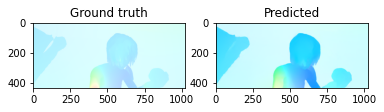

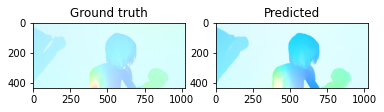

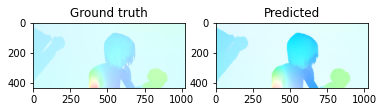

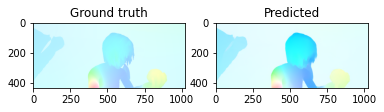

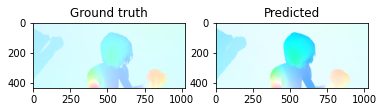

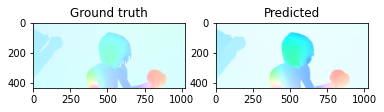

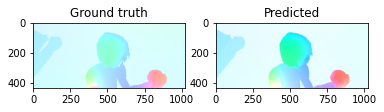

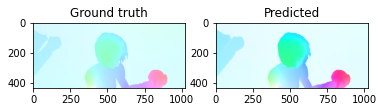

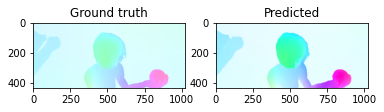

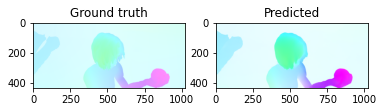

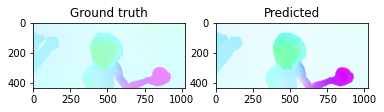

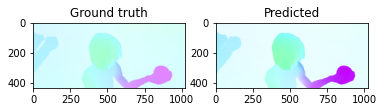

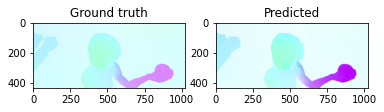

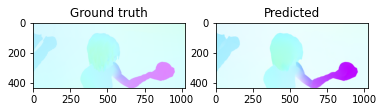

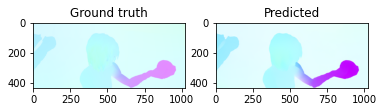

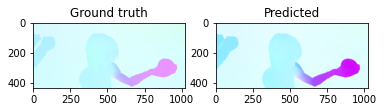

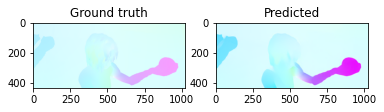

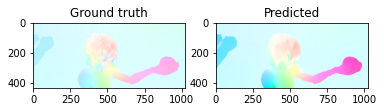

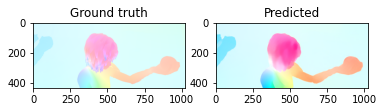

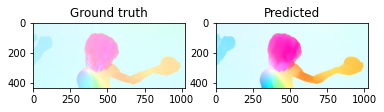

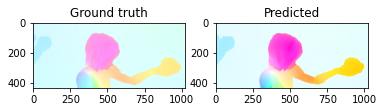

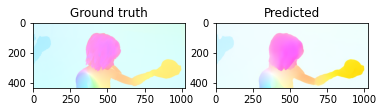

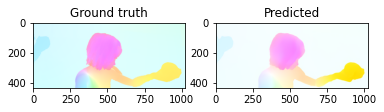

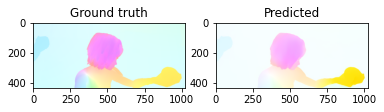

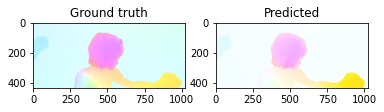

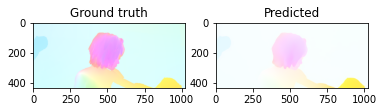

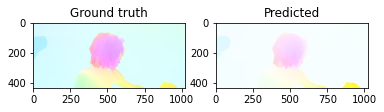

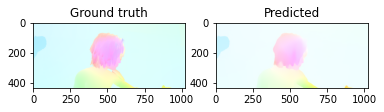

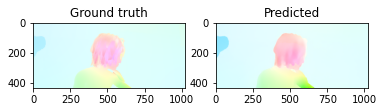

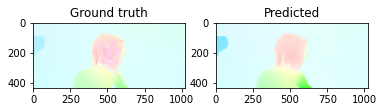

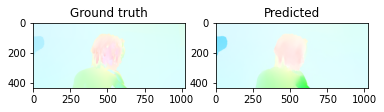

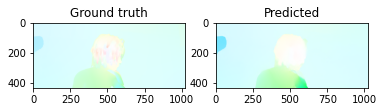

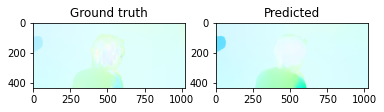

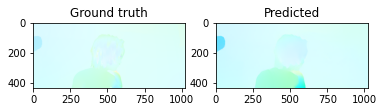

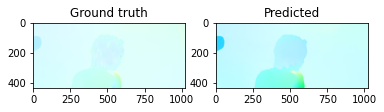

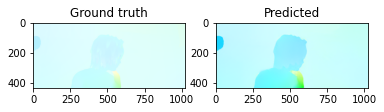

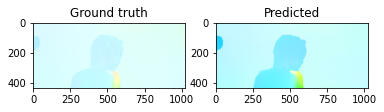

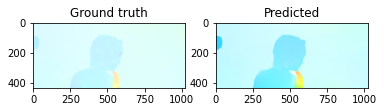

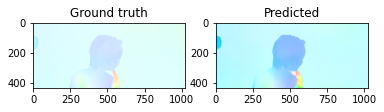

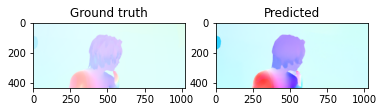

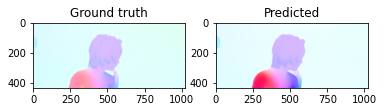

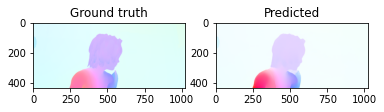

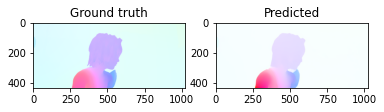

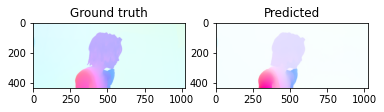

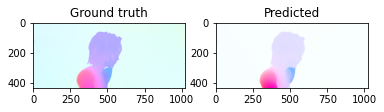

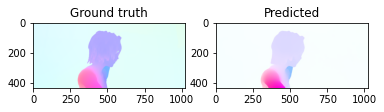

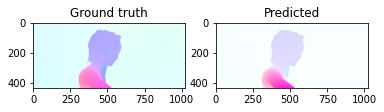

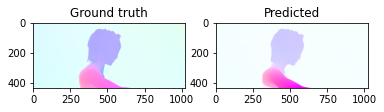

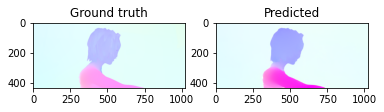

In [24]:
frames = sorted(glob(os.path.join(frames_path, '*.png')))
flows_gt = sorted(glob(os.path.join(flows_gt_path, '*.flo')))
color_flows = sorted(glob(os.path.join(color_flows_path, '*.png')))

evaluate_folder(model,frames,flows_gt,color_flows)

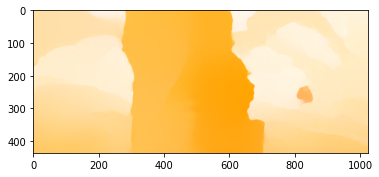

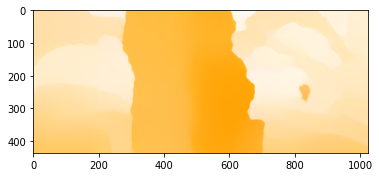

KeyboardInterrupt: 

In [25]:
evaluate_test = False

if evaluate_test:
    model.eval()
    flow_prev, sequence_prev = None, None
    with torch.no_grad():
        for dstype in ['clean', 'final']:
            test_dataset = MpiSintel(split='test',root=data_path, aug_params=None, dstype=dstype)
            for test_id in range(len(test_dataset)):
                image1, image2, (sequence, frame) = test_dataset[test_id]
                if sequence != sequence_prev:
                    flow_prev = None
                padder = InputPadder(image1.shape)
                image1, image2 = padder.pad(image1[None].to(device), image2[None].to(device))

                flow_low, flow_pr = model.module(image1, image2, iters=32, flow_init=flow_prev, test_mode=True)
                flow = padder.unpad(flow_pr[0]).permute(1, 2, 0).cpu().numpy()

                if test_id%100==0:
                    color_flow = flow_vis.flow_to_color(flow, convert_to_bgr=False)
                    plt.imshow(color_flow)
                    plt.show()
                
                output_dir = os.path.join(output_path, dstype, sequence)
                output_file = os.path.join(output_dir, 'frame%04d.flo' % (frame+1))

                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                writeFlow(output_file, flow)
                sequence_prev = sequence